# Loading libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd


from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping


from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.mobilenet import MobileNet

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from glob import glob
#import matplotlib.pyplot 

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

!pip install opencv-python

# Loading data

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'images/train_images_amazon'
valid_path = 'images/test_images_flipkart'

# Building Model 

**1.loading the models with no last layer**

In [3]:
 #Import the  library and add preprocessing layer to the front of transfer models
# Here we will be using imagenet weights

vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


1. The weights used are of imagenet
2. The include_top=False, means the last layer is getting removed

In [4]:
# don't train existing layers- weights will change otherwise
for layer in vgg16.layers:
    layer.trainable = False
    
for layer in vgg19.layers:
    layer.trainable = False
    
for layer in resnet.layers:
    layer.trainable = False


    

**2.Flattening the output**

In [33]:
# our layers - you can add more if you want
x1 = Flatten()(vgg16.output)

x2 = Flatten()(vgg19.output)

x3 = Flatten()(resnet.output)





**3.Checking our folder**

In [6]:
# useful for getting number of output classes
folders = glob('images/train_images_amazon/*')
folders

['images/train_images_amazon\\Jeans',
 'images/train_images_amazon\\sarees',
 'images/train_images_amazon\\Trousers']

In [7]:
len(folders)

3

**4.Appending folders as Dense Layer with activation function softmax**

The folders will get appended as last layer with the flattened x

In [8]:
prediction1 = Dense(len(folders), activation='softmax')(x1)

prediction2 = Dense(len(folders), activation='softmax')(x2)

prediction3 = Dense(len(folders), activation='softmax')(x3)



In [9]:
print(prediction1)
print(prediction2)
print(prediction3)


KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense_2/Softmax:0', description="created by layer 'dense_2'")


**5.Creating final model**

In [10]:
# create a model object
model1 = Model(inputs=vgg16.input, outputs=prediction1)

model2 = Model(inputs=vgg19.input, outputs=prediction2)

model3 = Model(inputs=resnet.input, outputs=prediction3)


In [11]:
# view the structure of the model
print("--------model vgg16----------------------------------------------------------")
print(model1.summary())

print("--------model vgg19----------------------------------------------------------")
print(model2.summary())

print("--------model resnet---------------------------------------------------------")
print(model3.summary())



--------model vgg16----------------------------------------------------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                 

In [22]:

model1.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)




# Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Applying data augmentation
#making sure inputs are of same size

training_set = train_datagen.flow_from_directory('images/train_images_amazon',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')



Found 1063 images belonging to 3 classes.


In [14]:
#data augmentation
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory('images/test_images_flipkart',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 160 images belonging to 3 classes.


# Applying model on data

In [15]:
# fit the model
vgg16_model_fit = model1.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-15-9c8775406a34>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg16_model_fit = model1.fit_generator(


Epoch 1/25
34/34 [==============================] - 107s 3s/step - loss: 0.6247 - accuracy: 0.7178 - val_loss: 8.8683 - val_accuracy: 0.2062
Epoch 2/25
34/34 [==============================] - 108s 3s/step - loss: 0.2648 - accuracy: 0.8833 - val_loss: 7.8828 - val_accuracy: 0.2250
Epoch 3/25
34/34 [==============================] - 105s 3s/step - loss: 0.2059 - accuracy: 0.9097 - val_loss: 8.7312 - val_accuracy: 0.2250
Epoch 4/25
34/34 [==============================] - 108s 3s/step - loss: 0.1954 - accuracy: 0.9210 - val_loss: 9.1597 - val_accuracy: 0.1875
Epoch 5/25
34/34 [==============================] - 106s 3s/step - loss: 0.1517 - accuracy: 0.9407 - val_loss: 8.8249 - val_accuracy: 0.2125
Epoch 6/25
34/34 [==============================] - 107s 3s/step - loss: 0.1148 - accuracy: 0.9661 - val_loss: 9.6407 - val_accuracy: 0.0938
Epoch 7/25
34/34 [==============================] - 108s 3s/step - loss: 0.1279 - accuracy: 0.9558 - val_loss: 9.4853 - val_accuracy: 0.2062
Epoch 8/25
34

In [22]:
vgg19_model_fit = model2.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-22-183dbb783cba>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg19_model_fit = model2.fit_generator(


Epoch 1/25
34/34 [==============================] - 137s 4s/step - loss: 0.7539 - accuracy: 0.7046 - val_loss: 9.0534 - val_accuracy: 0.1500
Epoch 2/25
34/34 [==============================] - 139s 4s/step - loss: 0.3585 - accuracy: 0.8269 - val_loss: 8.7724 - val_accuracy: 0.2188
Epoch 3/25
34/34 [==============================] - 140s 4s/step - loss: 0.2924 - accuracy: 0.8702 - val_loss: 9.0847 - val_accuracy: 0.2000
Epoch 4/25
34/34 [==============================] - 140s 4s/step - loss: 0.2064 - accuracy: 0.9059 - val_loss: 9.2374 - val_accuracy: 0.2188
Epoch 5/25
34/34 [==============================] - 142s 4s/step - loss: 0.2562 - accuracy: 0.8946 - val_loss: 9.1290 - val_accuracy: 0.1000
Epoch 6/25
34/34 [==============================] - 147s 4s/step - loss: 0.1945 - accuracy: 0.9135 - val_loss: 9.0966 - val_accuracy: 0.1937
Epoch 7/25
34/34 [==============================] - 149s 4s/step - loss: 0.1198 - accuracy: 0.9520 - val_loss: 8.8562 - val_accuracy: 0.2000
Epoch 8/25
34

In [23]:
resnet_model_fit = model3.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-23-c6a7b7ad4102>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet_model_fit = model3.fit_generator(


Epoch 1/25
34/34 [==============================] - 77s 2s/step - loss: 2.2880 - accuracy: 0.4873 - val_loss: 5.3170 - val_accuracy: 0.1937
Epoch 2/25
34/34 [==============================] - 74s 2s/step - loss: 0.9142 - accuracy: 0.6529 - val_loss: 5.6431 - val_accuracy: 0.1937
Epoch 3/25
34/34 [==============================] - 68s 2s/step - loss: 0.8085 - accuracy: 0.6839 - val_loss: 5.1159 - val_accuracy: 0.0375
Epoch 4/25
34/34 [==============================] - 66s 2s/step - loss: 0.8660 - accuracy: 0.6679 - val_loss: 5.9019 - val_accuracy: 0.0188
Epoch 5/25
34/34 [==============================] - 71s 2s/step - loss: 0.7396 - accuracy: 0.7008 - val_loss: 6.2784 - val_accuracy: 0.1750
Epoch 6/25
34/34 [==============================] - 72s 2s/step - loss: 0.5102 - accuracy: 0.7620 - val_loss: 6.1013 - val_accuracy: 0.2250
Epoch 7/25
34/34 [==============================] - 71s 2s/step - loss: 0.5184 - accuracy: 0.7601 - val_loss: 6.2060 - val_accuracy: 0.2375
Epoch 8/25
34/34 [==

In [16]:
losses_vgg16=pd.DataFrame(model1.history.history)
print("VGG16-------------------------------------------\n",losses_vgg16)



VGG16-------------------------------------------
         loss  accuracy   val_loss  val_accuracy
0   0.624749  0.717780   8.868276       0.20625
1   0.264838  0.883349   7.882825       0.22500
2   0.205907  0.909690   8.731160       0.22500
3   0.195442  0.920978   9.159671       0.18750
4   0.151661  0.940734   8.824918       0.21250
5   0.114818  0.966134   9.640717       0.09375
6   0.127930  0.955786   9.485296       0.20625
7   0.125320  0.954845   9.637982       0.20000
8   0.115979  0.960489   9.666961       0.20000
9   0.081588  0.971778   9.757243       0.22500
10  0.081679  0.968015   9.725302       0.19375
11  0.073832  0.971778  10.104113       0.20000
12  0.063672  0.980245  10.413096       0.21250
13  0.079410  0.969896  10.435382       0.20625
14  0.068529  0.981185  10.163783       0.20000
15  0.062313  0.976482  10.537808       0.23750
16  0.059408  0.979304  10.613699       0.20625
17  0.066524  0.980245  10.614845       0.21875
18  0.074910  0.969896  11.208082     

In [28]:
losses_vgg19=pd.DataFrame(model2.history.history)
print("VGG19-------------------------------------------\n",losses_vgg19)


VGG19-------------------------------------------
         loss  accuracy   val_loss  val_accuracy
0   0.753900  0.704610   9.053354       0.15000
1   0.358494  0.826905   8.772440       0.21875
2   0.292374  0.870179   9.084745       0.20000
3   0.206357  0.905927   9.237411       0.21875
4   0.256231  0.894638   9.128996       0.10000
5   0.194459  0.913453   9.096599       0.19375
6   0.119792  0.952023   8.856198       0.20000
7   0.117472  0.950141   9.506765       0.23125
8   0.129897  0.947319   9.326757       0.22500
9   0.109580  0.957667   9.274500       0.20625
10  0.110601  0.961430   9.870240       0.18750
11  0.093205  0.966134   9.390417       0.18750
12  0.100013  0.968956   9.758562       0.15625
13  0.079220  0.967074   9.969254       0.16875
14  0.088204  0.974600   9.929247       0.19375
15  0.076140  0.974600   9.945505       0.16875
16  0.083946  0.971778  10.424762       0.21250
17  0.074864  0.972719  10.111658       0.18125
18  0.071235  0.974600  10.390721     

In [29]:

losses_resnet=pd.DataFrame(model3.history.history)
print("resnet-------------------------------------------\n",losses_resnet)

resnet-------------------------------------------
         loss  accuracy   val_loss  val_accuracy
0   2.288043  0.487300   5.317034       0.19375
1   0.914228  0.652869   5.643128       0.19375
2   0.808526  0.683913   5.115880       0.03750
3   0.865950  0.667921   5.901866       0.01875
4   0.739596  0.700847   6.278430       0.17500
5   0.510192  0.761994   6.101315       0.22500
6   0.518427  0.760113   6.205963       0.23750
7   0.570582  0.742239   6.212586       0.20625
8   0.445823  0.785513   6.699919       0.23750
9   0.830372  0.679210   6.835227       0.13750
10  0.717920  0.728128   8.851778       0.24375
11  0.690465  0.734713   7.418118       0.15000
12  0.652580  0.742239   7.173831       0.14375
13  0.731493  0.722484   8.535540       0.15625
14  0.476051  0.777046   8.215266       0.00625
15  0.419638  0.815616   7.313577       0.07500
16  0.743270  0.730009   9.729560       0.23125
17  0.523559  0.791157  10.974249       0.20000
18  0.468414  0.796802   9.639284    

Best model is vgg 16 with 16 epochs

# Accuracy of the model

Best accuracy is chosen as the model and stored as h5 file

In [20]:
import matplotlib.pyplot as plt

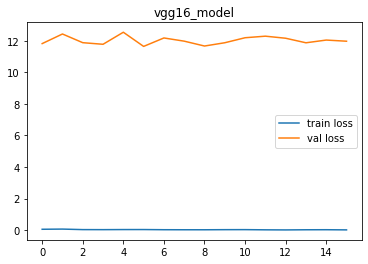

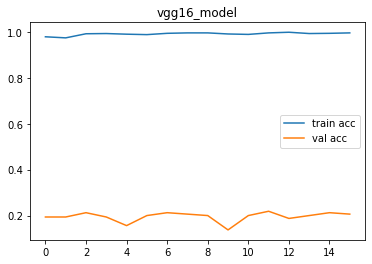

<Figure size 432x288 with 0 Axes>

In [21]:
# plot the loss

plt.plot(vgg16_model_fit.history['loss'], label='train loss')
plt.plot(vgg16_model_fit.history['val_loss'], label='val loss')
plt.legend()
plt.title("vgg16_model")
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(vgg16_model_fit.history['accuracy'], label='train acc')
plt.plot(vgg16_model_fit.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("vgg16_model")
plt.show()
plt.savefig('AccVal_acc')

In [19]:
name_labels_df = pd.DataFrame(list(training_set.class_indices.items()),columns = ['names','labels'],index=None)
name_labels_df

,names,labels
0,Jeans,0
1,Trousers,1
2,sarees,2


# PREDICTION

In [26]:
from keras.preprocessing.image import load_img

In [38]:
# path to the train and test directory
train_path = 'D:/folders/fliprobo/assignment 13/assignment 13/images/train_images_amazon'
test_path = 'D:/folders/fliprobo/assignment 13/assignment 13/images/test_images_flipkart'

# getting all the images path from train, test directories respectively ..

train_files = glob(train_path + "/*/*.jpg")
test_files = glob(test_path + "/*/*.jpg")

In [41]:
#predicting any random image
import numpy as np
from keras.preprocessing import image


def predict_random_image():
  img = image.load_img(np.random.choice(test_files), target_size=IMAGE_SIZE)
  x = image.img_to_array(img)
  plt.imshow(img)
  x = np.expand_dims(x, axis=0) /255.0
  result_df = pd.DataFrame(list(model1.predict(x)[0]),index=name_labels_df.names.values,columns=['result'])
  print(result_df.result.idxmax())

sarees


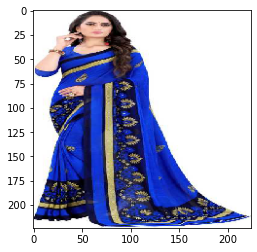

In [42]:
predict_random_image()

Trousers


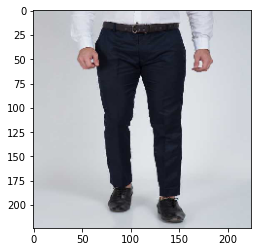

In [43]:
predict_random_image()

Jeans


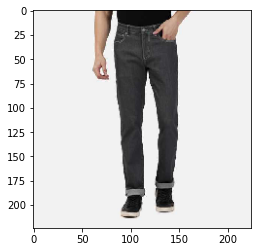

In [44]:
predict_random_image()

Hence the model final_vgg16_model_fit can predict the images well

# Saving the model

In [ ]:
# save it as a h5 file
from tensorflow.keras.models import load_model
vgg16_model_fit.save('model_final_vgg16.h5')

In [ ]:
y_pred = final_vgg16_model_fit.predict(test_set)

In [ ]:
y_pred

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

----------------------------------------------MODEL IS BUILT---------------------------------------------------------------